In [7]:
import numpy as np
import pandas as pd

import altair as alt
# Save a vega-lite spec and a PNG blob for each plot in the notebook
alt.renderers.enable("mimetype")
# Handle large data sets without embedding them in the notebook
alt.data_transformers.enable("data_server")
alt.data_transformers.disable_max_rows()

import copy
import os
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    plot_confusion_matrix,
)
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split

# pip install git+git://github.com/mgelbart/plot-classifier.git
from plot_classifier import plot_classifier

In [2]:
sap_sugar_df = pd.read_pickle('data/processed/stinson2019/norm_tables/sap_sugar_weekly_summary')

gdd_frthw = pd.read_pickle('data/processed/stinson2019/norm_tables/gdd_frthw')
closest_weather_stn = pd.read_pickle('data/processed/stinson2019/norm_tables/closest_weather_stn')
gdd_frthw = gdd_frthw.merge(closest_weather_stn.reset_index(), how = 'left', on= 'stn_id')
gdd_frthw = gdd_frthw.set_index('datetime')

full_weekly = pd.read_pickle('data/processed/stinson2019/full_weekly_summary')


In [3]:
location = pd.read_pickle('data/processed/stinson2019/norm_tables/location')
sap_sugar_df
location

,lat,lon,short_name,long_name,state_province
site,,,,,
DOF,43.733800,-72.249000,Dartmouth,Dartmouth Organic Farm,NH
QC,48.430919,-70.688456,Boris,Boris,QC
HF,42.531500,-72.189900,Harvard,Harvard Forest,MA
INDU,41.625400,-87.081100,Indiana Dunes,Indiana Dunes National Lakeshore,IN
SMM,38.235181,-79.657058,Southernmost,Southernmost Maple,VA
DR,37.010800,-82.676400,Divide Ridge,Divide Ridge,VA


In [10]:
sap_sugar_df

,tap_id,date_from,date_to,weekly_sugarwt,weekly_sap,site
0,DOF1A,2014-03-05,2014-03-11,0.00036,0.03,DOF
1,DOF1A,2014-03-06,2014-03-12,0.00036,0.03,DOF
2,DOF1A,2014-03-07,2014-03-13,0.00036,0.03,DOF
3,DOF1A,2014-03-08,2014-03-14,0.00036,0.03,DOF
4,DOF1A,2014-03-09,2014-03-15,0.00036,0.03,DOF
...,...,...,...,...,...,...
21570,SMAS8B,2016-02-27,2016-03-04,0.73113,34.63,SMM
21571,SMAS8B,2016-02-28,2016-03-05,0.73113,34.63,SMM
21572,SMAS8B,2016-02-29,2016-03-06,0.72000,36.53,SMM
21573,SMAS8B,2016-03-01,2016-03-07,0.55602,27.42,SMM


In [16]:
gdd_frthw

,stn_id,mean_airt,GDD,cumGDD,frthw,site
datetime,,,,,,
2016-01-01,726358-00384,-3.527778,0.0,0.000000,0.0,INDU
2016-01-02,726358-00384,-1.000000,0.0,0.000000,0.0,INDU
2016-01-03,726358-00384,0.027778,0.0,0.000000,0.0,INDU
2016-01-04,726358-00384,-0.930556,0.0,0.000000,0.0,INDU
2016-01-05,726358-00384,-4.541667,0.0,0.000000,0.0,INDU
...,...,...,...,...,...,...
2017-12-27,726116-94765,-17.854839,0.0,2191.779495,119.0,DOF
2017-12-28,726116-94765,-21.370000,0.0,2191.779495,119.0,DOF
2017-12-29,726116-94765,-20.778788,0.0,2191.779495,119.0,DOF


In [58]:
gdd_frthw.index.year==2016

array([ True,  True,  True, ..., False, False, False])

In [36]:
sap_sugar_df['datetime'] = pd.to_datetime(sap_sugar_df['date_from'].dt.date + (sap_sugar_df['date_to'].dt.date-sap_sugar_df['date_from'].dt.date)/2)
sap_sugar_df.datetime.dtype

dtype('<M8[ns]')

In [59]:
sap_sugar_df[(sap_sugar_df.site==site) & (sap_sugar_df.tap_id=='DOF8A')].merge(gdd_frthw[(gdd_frthw.site==site) & (gdd_frthw.index.year==2014)], how='right', on = ['datetime', 'site']).iloc[:]

,tap_id,date_from,date_to,weekly_sugarwt,weekly_sap,site,datetime,stn_id,mean_airt,GDD,cumGDD,frthw
0,NaN,NaT,NaT,NaN,NaN,DOF,2014-01-01,726116-94765,-12.637500,0.0,0.000000,0.0
1,NaN,NaT,NaT,NaN,NaN,DOF,2014-01-02,726116-94765,-15.128571,0.0,0.000000,0.0
2,NaN,NaT,NaT,NaN,NaN,DOF,2014-01-03,726116-94765,-16.711475,0.0,0.000000,0.0
3,NaN,NaT,NaT,NaN,NaN,DOF,2014-01-04,726116-94765,-20.695833,0.0,0.000000,0.0
4,NaN,NaT,NaT,NaN,NaN,DOF,2014-01-05,726116-94765,-10.392000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
360,NaN,NaT,NaT,NaN,NaN,DOF,2014-12-27,726116-94765,0.308333,0.0,2051.455256,121.0
361,NaN,NaT,NaT,NaN,NaN,DOF,2014-12-28,726116-94765,3.952778,0.0,2051.455256,122.5
362,NaN,NaT,NaT,NaN,NaN,DOF,2014-12-29,726116-94765,0.066667,0.0,2051.455256,123.0
363,NaN,NaT,NaT,NaN,NaN,DOF,2014-12-30,726116-94765,-7.829167,0.0,2051.455256,123.0


In [60]:
sap_sugar_df.datetime.dt.year.unique()

array([2014, 2015, 2016, 2017, 2012, 2013])

In [34]:
# Add datetime column to sap_sugar_df containing the halfway date between date_from and date_to
sap_sugar_df['datetime'] = sap_sugar_df['date_from'].dt.date + (sap_sugar_df['date_to'].dt.date-sap_sugar_df['date_from'].dt.date)/2

full_sap = pd.DataFrame(columns = ['tap_id', 'date_from', 'date_to', 'weekly_sugarwt', 'weekly_sap', 'site', 'cum_GDD', 'cum_frthw', 'weekly_frthw', 'sap_binary'])

for site in sap_sugar_df.site.unique():
    sap_sugar_site = sap_sugar_df[sap_sugar_df.site==site]
    for tap in sap_sugar_site.tap_id.unique():
        sap_sugar_tap = sap_sugar_site[sap_sugar_site.tap_id==tap]
        for year in sap_sugar_tap.datetime.dt.year.unique():
            sap_sugar_year = sap_sugar_tap[sap_sugar_tap.datetime.dt.year == year]
            
            # should use date-to instead of datetime for sap_sugar_year
            sap_sugar_year = sap_sugar_year.merge(gdd_frthw[(gdd_frthw.site==site) & (gdd_frthw.index.year==2014)], how='right', on = ['datetime', 'site'])
            sap_sugar_year.loc[:,'weekly_frthw'] = sap_sugar_site.loc[:,'cum_frthw'] - sap_sugar_site['date_from'].apply(lambda x: gdd_frthw_site.loc[x]['frthw'])  # Add total weekly freeze-thaw cycles column
            sap_sugar_site['sap_binary'] = sap_sugar_site['weekly_sap'].apply(lambda x: 0 if ((pd.isnull(x)) | (x==0)) else 1)  # Add column indicating if there was any sap flow in a given week
            full_sap = full_sap.append(sap_sugar_site)

full_sap.sap_binary = full_sap.sap_binary.astype('int')
       

/home/steffen/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


ValueError: You are trying to merge on object and datetime64[ns] columns. If you wish to proceed you should use pd.concat

In [17]:
# Add datetime column to sap_sugar_df containing the halfway date between date_from and date_to
sap_sugar_df['datetime'] = sap_sugar_df['date_from'].dt.date + (sap_sugar_df['date_to'].dt.date-sap_sugar_df['date_from'].dt.date)/2

full_sap = pd.DataFrame(columns = ['tap_id', 'date_from', 'date_to', 'weekly_sugarwt', 'weekly_sap', 'site', 'cum_GDD', 'cum_frthw', 'weekly_frthw', 'sap_binary'])

for site in sap_sugar_df.site.unique():
    sap_sugar_site = copy.copy(sap_sugar_df[sap_sugar_df.site==site])
    gdd_frthw_site = copy.copy(gdd_frthw[gdd_frthw.site==site])
    sap_sugar_site = sap_sugar_site.assign(cum_GDD = sap_sugar_site.loc[:,'date_to'].apply(lambda x: gdd_frthw_site.loc[x]['cumGDD']), # Add cumulative GDD column
                                           cum_frthw = sap_sugar_site.loc[:,'date_to'].apply(lambda x: gdd_frthw_site.loc[x]['frthw']))  # Add cumulative freeze-thaw cycles column
    sap_sugar_site.loc[:,'weekly_frthw'] = sap_sugar_site.loc[:,'cum_frthw'] - sap_sugar_site['date_from'].apply(lambda x: gdd_frthw_site.loc[x]['frthw'])  # Add total weekly freeze-thaw cycles column
    sap_sugar_site['sap_binary'] = sap_sugar_site['weekly_sap'].apply(lambda x: 0 if ((pd.isnull(x)) | (x==0)) else 1)  # Add column indicating if there was any sap flow in a given week
    full_sap = full_sap.append(sap_sugar_site)

full_sap.sap_binary = full_sap.sap_binary.astype('int')
       

/home/steffen/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/datetimelike.py:1108: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized
  warnings.warn(


In [94]:
full_sap

,tap_id,date_from,date_to,weekly_sugarwt,weekly_sap,site,cum_GDD,cum_frthw,weekly_frthw,sap_binary
0,DOF1A,2014-03-05,2014-03-11,0.00036,0.03,DOF,1.956098,24.5,3.5,1
1,DOF1A,2014-03-06,2014-03-12,0.00036,0.03,DOF,1.956098,25.0,4.0,1
2,DOF1A,2014-03-07,2014-03-13,0.00036,0.03,DOF,1.956098,25.0,3.0,1
3,DOF1A,2014-03-08,2014-03-14,0.00036,0.03,DOF,1.956098,25.0,2.0,1
4,DOF1A,2014-03-09,2014-03-15,0.00036,0.03,DOF,1.956098,25.5,2.5,1
...,...,...,...,...,...,...,...,...,...,...
21570,SMAS8B,2016-02-27,2016-03-04,0.73113,34.63,SMM,22.598669,31.0,1.0,1
21571,SMAS8B,2016-02-28,2016-03-05,0.73113,34.63,SMM,22.598669,32.5,2.0,1
21572,SMAS8B,2016-02-29,2016-03-06,0.72000,36.53,SMM,22.598669,34.0,3.5,1
21573,SMAS8B,2016-03-01,2016-03-07,0.55602,27.42,SMM,22.598669,34.5,4.0,1


sap_sugar_sitealysis, Houle et al. (2015) created a logistic regression model to predict the presence or absence of maple syrup production in a given week.  The following linear function was developed based on their measured data (note: signs have been reversed:

$$ P = -5.09 + 0.722F - 0.014F^2 - 0.07G$$

Where:

$P$ = Predictor of whether there will or will not be sap flowing in a given week (variable is labelled 'Production' in Houle et al., 2015)

$F$ = Cumulative number of freeze/thaw events since the beginning of the year (January 1st).  A freeze/thaw event is counted if the temperature rises above a given threshold ($T_{thresh}$) and drops below it again.  A threshold of 3&deg;C has been used as in Houle et al., 2015.

$G$ = Cumulative number of growing degree days since the beginning of the year (January 1st) using a 5&deg;C base temperature ($T_{base}$).  Each day, the maximum air temperature ($T_{max}$is extracted and, if it is above the $T_{base}$, a value of $T_{base} - T_{max}$ is added to the running total of growing degree days ($G$).

Passing $P$ into a sigmoid function and applying a threshold of 0.51, we end up with a prediction of whether there will or will not be sap flow in a given week.

$$\hat{Y} = \begin{cases}
1 & \text{if} \ \frac{1}{1+e^{-P}} \geq 0.51 \\
0 & \text{if} \ \frac{1}{1+e^{-P}} < 0.51
\end{cases}
$$


In [112]:
# Coefficients of linear model created by Houle 2015
houle_coeff = np.array([-5.09, 0.733, -0.014, -0.07])
houle_thresh = 0.   

# Create dataframe of parameters required for Houle 2015 analysis
houle2015 = full_sap[['site', 'tap_id', 'date_from', 'date_to', 'cum_frthw', 'cum_GDD', 'sap_binary']]
houle2015 = houle2015.rename(columns={'cum_frthw':'F', 'cum_GDD':'G', 'sap_binary':'Y'})


# Add F**2 column
houle2015['F2'] = houle2015.F**2



# Add bias column
houle2015['bias'] = 1
houle2015.loc[:,'P'] = houle2015[['bias', 'F', 'F2', 'G']]@(houle_coeff) 
houle2015.loc[:,'S'] = 1/(1 + np.exp(-houle2015['P']))  # Add intermediate sigmoid output column 'S'
houle2015.loc[:,'Y_hat'] = (houle2015['S'] > houle_thresh).astype('int') # Threshold determined by Houle 2015


In [139]:
houle2015['jd'] = (houle2015['date_from'].dt.dayofyear+houle2015['date_to'].dt.dayofyear)
houle2015['year'] = houle2015['date_from'].dt.year

In [140]:
houle2015

,site,tap_id,date_from,date_to,F,G,Y,F2,bias,P,S,Y_hat,jd,year
0,DOF,DOF1A,2014-03-05,2014-03-11,24.5,1.956098,1,600.25,1,4.328073,0.986979,1,134,2014
1,DOF,DOF1A,2014-03-06,2014-03-12,25.0,1.956098,1,625.00,1,4.348073,0.987233,1,136,2014
2,DOF,DOF1A,2014-03-07,2014-03-13,25.0,1.956098,1,625.00,1,4.348073,0.987233,1,138,2014
3,DOF,DOF1A,2014-03-08,2014-03-14,25.0,1.956098,1,625.00,1,4.348073,0.987233,1,140,2014
4,DOF,DOF1A,2014-03-09,2014-03-15,25.5,1.956098,1,650.25,1,4.361073,0.987396,1,142,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21570,SMM,SMAS8B,2016-02-27,2016-03-04,31.0,22.598669,1,961.00,1,2.597093,0.930674,1,122,2016
21571,SMM,SMAS8B,2016-02-28,2016-03-05,32.5,22.598669,1,1056.25,1,2.363093,0.913969,1,124,2016
21572,SMM,SMAS8B,2016-02-29,2016-03-06,34.0,22.598669,1,1156.00,1,2.066093,0.887564,1,126,2016
21573,SMM,SMAS8B,2016-03-01,2016-03-07,34.5,22.598669,1,1190.25,1,1.953093,0.875784,1,128,2016


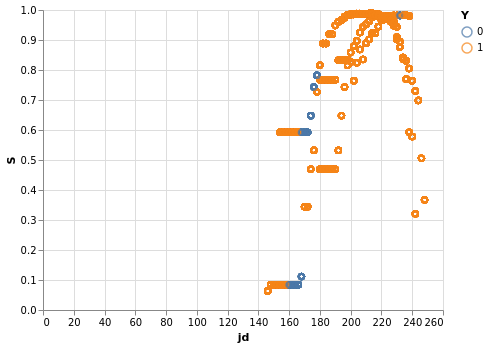

In [134]:
alt.Chart(houle2015[houle2015.site=='QC']).mark_point().encode(x = 'jd', y = 'S', color = 'Y:N')

In [138]:
tn, fp, fn, tp = confusion_matrix(houle2015[houle2015.site=='QC']['Y'], houle2015[houle2015.site=='QC']['Y_hat']).ravel()
(tn, fp, fn, tp)

(100, 146, 380, 2274)

In [137]:
print(classification_report(houle2015[houle2015.site=='QC']['Y'], houle2015[houle2015.site=='QC']['Y_hat']))

              precision    recall  f1-score   support

           0       0.21      0.41      0.28       246
           1       0.94      0.86      0.90      2654

    accuracy                           0.82      2900
   macro avg       0.57      0.63      0.59      2900
weighted avg       0.88      0.82      0.84      2900



In [164]:
X = houle2015[houle2015.site=='QC'][['F','F2', 'G']]
y = houle2015[houle2015.site=='QC']['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 123, stratify = houle2015[houle2015.site=='QC'].year)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logreg.score(X_test,y_test)


0.9137931034482759

In [168]:
X = houle2015[houle2015.site=='QC'][['F','F2', 'G']]
y = houle2015[houle2015.site=='QC']['Y']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 123, stratify = houle2015[houle2015.site=='QC'].year)
logreg_cv = LogisticRegressionCV(scoring='f1')
logreg_cv.fit(X_train, y_train)
logreg_cv.score(X_test,y_test)

0.9549549549549551

In [142]:
print(logreg.intercept_, logreg.coef_)

[-0.49157104] [[ 0.27405657 -0.00367647  0.04023661]]


In [147]:
# Test Houle parameters
logreg.intercept_ = [-5.09]
logreg.coef_ = np.array([[0.733, -0.014, -0.07]])
logreg.score(X_train,y_train)

0.8198275862068966

In [148]:
print(logreg.intercept_, logreg.coef_)

[-5.09] [[ 0.733 -0.014 -0.07 ]]


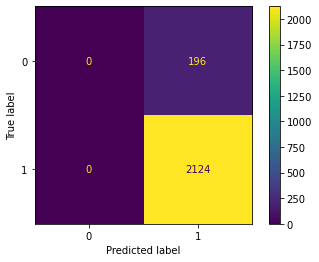

In [169]:
plot_confusion_matrix(logreg_cv, X_train,y_train)

In [19]:
opt = {'--location':'all','--tree':'all', '--tap': 'all', '--years': 'all', '--species': 'ACSA'}

In [22]:
def add_ids(data):
    """Add unique record ids for each entry in sap dataframe

    Parameters
    ----------
    data : DataFrame
        Dataframe containing sap records

    Returns
    -------
    DataFrame
        Dataframe same as input but with new column containing a
        unique record id for each entry of the form:
        
        '<TreeID>_<TapID>_<RecordYear>_<ID#>'

        where ID# is 0 for the first record for a given tap in <RecordYear>, 
        1 is the second record of the year, etc.
    """
    
    id_df = data.sort_values(["site", "tree", "tap", "date"])

    # Create unique record ids for each entry in the following form:
    # "<TreeID>_<TapID>_<RecordYear>_<ID#>" where ID# is 0 for the first
    # record for a given tap in <RecordYear>, 1 is the second ...

    # First create "<TreeID>_<TapID>_<RecordYear>_" label for each record_id
    id_df["record_id"] = (
        +id_df["tree"]
        + "_"
        + id_df["tap"]
        + "_"
        + pd.DatetimeIndex(id_df["year"]).year.astype(str)
        + "_"
    )

    # Add "<ID#>" to each record_id
    for tapyear in id_df["record_id"].unique():
        id_df.loc[id_df["record_id"] == tapyear, "record_id"] += [
            str(i) for i in range(id_df[id_df["record_id"] == tapyear].shape[0])
        ]

    id_df["tap_id"] = id_df["tree"] + id_df["tap"]
    
    return id_df

In [23]:
def normalized_tables(data):
    """Create normalized tables from wide dataframe of sap measurements

    Parameters
    ----------
    data : DataFrame
        Wide dataframe of sap measurements

    Returns
    -------
    dict
        Dict of 7 normalized dataframes: tap_records, sap, sugar, dates, tap_tree, tree_species, site
    """
    df = {}

    df["tap_records"] = data[["record_id", "tap_id"]].set_index("record_id")
    df["sap"] = (
        data[["record_id", "sap_wt"]]
        .rename(columns={"sap_wt": "sap"})
        .set_index("record_id")
    )
    df["sugar"] = data[["record_id", "sugar"]].set_index("record_id")
    df["dates"] = data[["record_id", "date"]].set_index("record_id")
    df["dates"].loc[:, "date"] = pd.to_datetime(df["dates"]["date"])
    df["tap_tree"] = data[["tap_id", "tree"]].drop_duplicates().set_index("tap_id")
    df["tree_species"] = data[["tree", "species"]].drop_duplicates().set_index("tree")
    df["site"] = data[["tree", "site"]].drop_duplicates().set_index("tree")
    df["site"]["site"] = df['site']["site"].str.upper()

    return df

In [24]:

loc = opt['--location']
tre = opt['--tree']
tp = opt['--tap']
yrs = opt['--years']
spec = opt['--species']

processed_path = "../data/processed/stinson2019"

if not os.path.exists(processed_path):
    os.makedirs(processed_path)

# Load sap flow data
stinson2019 = pd.read_pickle(processed_path + "/stinson2019_df")

data = add_ids(stinson2019) # Add unique record id column to dataframe
normalized_data = normalized_tables(data) # Move data to normalized tables

In [84]:
import time

before = time.time()
# def get_weekly_data(normalized_data,location=["all"],tree="all", tap_id="all", years="all", species="ACSA",):
#     """Generate data table containing cumulative weekly sap and sugar amounts

#     Parameters
#     ----------
#     normalized_data : list
#         List of normalized dataframes from `normalized_tables` function.
#     location : str or list of str, optional
#         Name of locations (sites) to be included in data table, by default 'all'
#     tree : str or list of str, optional
#         ID of trees to be included in data table, by default 'all'
#     tap_id : str or list of str, optional
#         ID of taps to be included in data table, by default 'all'
#     years : int, list of ints, or 'all' , optional
#         Years to be included in data table, by default 'all'
#     species : str, list of str, or 'all' , optional
#         Species to be included in data table, by default 'ACSA' (sugar maple)

#     Returns
#     -------
#     pd.DataFrame
#         Table with weekly summaries for all taps specified in arguments.  Includes
#         cumulative sap and sugar weight, and weekly sap and sugar weight.
#     """
    
# Unpack normalized DataFrames
tap_records, sap, sugar, dates, tap_tree, tree_species, site = normalized_data.values()

location=loc
tree=tre
tap_id=tp
years=yrs
species=spec

# Check and clean location argument
if type(location) != list:
    location = [location]
location = [x.upper() for x in location]
if location == ["ALL"]:
    location = site["site"].unique().tolist()

# Check and clean tap_id argument
if type(tap_id) != list:
    tap_id = [tap_id]
tap_id = [x.upper() for x in tap_id]
if tap_id == ["ALL"]:
    tap_id = tap_tree.index.tolist()

# Check and clean tree argument
if type(tree) != list:
    tree = [tree]
tree = [x.upper() for x in tree]
if tree == ["ALL"]:
    tree = tap_tree["tree"].unique().tolist()

# Check and clean years argument
if type(years) != list:
    years = [years]
if type(years[0]) == str:
    years[0] = years[0].upper()
    if years == ["ALL"]:
        years = pd.DatetimeIndex(dates["date"]).year.unique().tolist()

# Check and clean species argument
if type(species) != list:
    species = [species]
species = [x.upper() for x in species]
if species == ["ALL"]:
    species = tree_species["species"].unique().tolist()

tap_id = (
    tap_tree[tap_tree.index.isin(tap_id)]
    .join(site, how="left", on="tree")
    .reset_index()
    .merge(tree_species, how="left", on="tree")
    .set_index("tap_id")
)
tap_id = tap_id[
    (tap_id["tree"].isin(tree))
    & (tap_id["site"].isin(location))
    & (tap_id["species"].isin(species))
].index.tolist()

# Initialize summary dataframe
weekly_df = pd.DataFrame()

# Create weekly summaries, iterating through all taps
for tap in tap_id:
    #         print("tap:  ", tap)
    # Create joint dataframe will all required info for current tap
    df = (
        tap_records.join(tap_tree[tap_tree.index == tap], how="right", on="tap_id")
        .join(sap, how="left")
        .join(sugar, how="left")
        .join(dates[pd.DatetimeIndex(dates["date"]).year.isin(years)], how="inner")
    )
    df["year"] = pd.DatetimeIndex(df["date"]).year
    df["jd"] = pd.DatetimeIndex(df["date"]).dayofyear

    for year in df["year"].unique():
        #             print('     year: ', year)
        df_year = df[df["year"] == year]

        # Deal with multiple entries per day.  Sap taken as sum of measurements, sugar content as weighted average.
        if not df_year["jd"].is_unique:
            df_year_temp = copy.copy(df_year)
            df_year_temp["product"] = df_year_temp.sap * df_year_temp.sugar.fillna(
                value=df_year_temp.sugar.mean()
            )
            df_year_temp = df_year_temp.groupby(by="jd").sum().reset_index()
            df_year_temp["sugar"] = df_year_temp["product"] / df_year_temp["sap"]
            df_year = df_year.drop_duplicates(subset="jd")
            df_year = (
                df_year.reset_index()
                .merge(
                    df_year_temp[["jd", "sap", "sugar"]],
                    on="jd",
                    how="right",
                    suffixes=["", "_sum"],
                )
                .set_index("record_id")
            )
            df_year["sap"] = df_year["sap_sum"]
            df_year["sugar"] = df_year["sugar_sum"]
            df_year = df_year.drop(columns=["sap_sum", "sugar_sum"])

        # Add entry for every day of year from first day with recorded flow to last
        df_year = (
            df_year.reset_index()
            .merge(
                pd.date_range(
                    start=df_year["date"].min(), end=df_year["date"].max()
                ).to_frame(name="date"),
                how="right",
                on="date",
            )
            .set_index("date", drop=False)
        )

        # Assumption: missing sugar content should be filled with mean sugar content
        df_year["sugarwt"] = (
            df_year.sap * df_year.sugar.fillna(value=df_year.sugar.mean()) / 100
        )

        # Assumption: missing sap values should be replaced with zeros
        df_year["cum_sap"] = df_year.sap.fillna(value=0).cumsum()
        df_year["cum_sugarwt"] = df_year.sugarwt.fillna(value=0).cumsum()
        df_year["tap_id"] = df_year.tap_id.fillna(value=tap)
        df_year["tree"] = df_year.tree.fillna(value=df_year.tree[0])
        df_year["year"] = pd.DatetimeIndex(df_year["date"]).year
        df_year["jd"] = pd.DatetimeIndex(df_year["date"]).dayofyear
        
        if df_year.shape[0] > 7:
            df_year['weekly_sap'] = df_year.loc[:,'cum_sap'].to_numpy() - np.concatenate((np.zeros(7), df_year.iloc[:-7]['cum_sap'].to_numpy()),axis=0)
            df_year['weekly_sugarwt'] = df_year.loc[:,'cum_sugarwt'].to_numpy() - np.concatenate((np.zeros(7), df_year.iloc[:-7]['cum_sugarwt'].to_numpy()),axis=0)
        else:
            df_year['weekly_sap'] = df_year['cum_sap']
            df_year['weekly_sugarwt'] = df_year['cum_sugarwt']
            
        df_year["cum_syrupLitres"] = df_year["cum_sugarwt"] / 1.33
        df_year["weekly_syrupLitres"] = df_year["weekly_sugarwt"] / 1.33
        

#         for day in df_year.index[6:]:
#             if df_year["date"].min() == (day - pd.to_timedelta(6, unit="D")):
#                 df_year.loc[day, "weekly_sap"] = df_year.loc[day]["cum_sap"]
#                 df_year.loc[day, "weekly_sugarwt"] = df_year.loc[day]["cum_sugarwt"]
#             else:
#                 df_year.loc[day, "weekly_sap"] = (
#                     df_year.loc[day]["cum_sap"]
#                     - df_year.loc[day - pd.to_timedelta(7, unit="D")]["cum_sap"]
#                 )
#                 df_year.loc[day, "weekly_sugarwt"] = (
#                     df_year.loc[day]["cum_sugarwt"]
#                     - df_year.loc[day - pd.to_timedelta(7, unit="D")]["cum_sugarwt"]
#                 )
#                 df_year.loc[day, "cum_syrupLitres"] = (
#                     df_year.loc[day, "cum_sugarwt"] / 1.33
#                 )
#                 df_year.loc[day, "weekly_syrupLitres"] = (
#                     df_year.loc[day, "weekly_sugarwt"] / 1.33
#                 )

        df_year["date_from"] = df_year["date"] - pd.to_timedelta(6, unit="D")
        df_year["date_to"] = df_year["date"]
        df_year["jd_from"] = df_year["jd"] - 6
        df_year["jd_to"] = df_year["jd"]
        df_year = df_year.drop(columns=["date", "jd", "record_id"])

        weekly_df = weekly_df.append(df_year[6:])

#     return weekly_df
print(before - time.time())

-8.17181134223938


In [82]:
np.concatenate((np.zeros(7), df_year.iloc[:-7]['cum_sap'].to_numpy()),axis=0)

array([0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# full_df = get_weekly_data(normalized_data, location=loc, tree=tre, tap_id=tp, years=yrs, species=spec) # Calculate weekly summary parameters
full_df = full_df.reset_index().merge(normalized_data['site'], on='tree', how='left')
sap_sugar_df = full_df.loc[:,['date_from', 'date_to', 'weekly_sugarwt', 'weekly_sap','site']]

full_df.to_pickle(processed_path + '/full_weekly_summary')
sap_sugar_df.to_pickle(processed_path + '/sap_sugar_weekly_summary')

In [100]:
location = pd.read_csv('../data/raw/stinson2019/ACERnet_LatLon.csv')
location = location.rename(columns = {'Site':'acronym', 'Loc':'loc'})
df__sites = stinson2019['site'].unique()
location['site'] = [df_sites[1], df_sites[3], df_sites[0], df_sites[5], df_sites[2], df_sites[4]]
location = location.set_index('site')
location

,acronym,short_name,long_name,loc,lat,lon
site,,,,,,
Dartmouth Organic Farm,DOF,Dartmouth,Dartmouth Organic Farm,NH,43.733800,-72.249000
Northern range - Quebec,QB,Boris,Boris,QB,48.430919,-70.688456
Harvard Forest,HF,Harvard,Harvard Forest,MA,42.531500,-72.189900
INDU,INDU,Indiana Dunes,Indiana Dunes National Lakeshore,IN,41.625400,-87.081100
Southernmost Maple,SMM,Southernmost,Southernmost Maple,VA,38.235181,-79.657058
Divide Ridge,DR,Divide Ridge,Divide Ridge,VA,37.010800,-82.676400


In [105]:
closest_weather_stn = pd.DataFrame({'stn_id': ['HF001']},index = location.index)
closest_weather_stn

,stn_id
site,
Dartmouth Organic Farm,HF001
Northern range - Quebec,HF001
Harvard Forest,HF001
INDU,HF001
Southernmost Maple,HF001
Divide Ridge,HF001


In [ ]:
#Dartmouth Organic Farm: Lebanon Municipal Airport -- ID: USW00094765v